In [294]:
import pandas as pd
import string
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import pandasql as sqldf
import numpy as np

### Initial Model

To start, we are going to capture accuracy of a simple baseline model that we can use to benchmark

What we want to do is to "clean" our data. In this instance, we have to convert categorical variables into one hot encodings

In [295]:
df_initial = pd.read_csv("data.csv", sep=";")
df_initial = df_initial.loc[df_initial["Target"] != "Enrolled"]
df_initial

# for this exercise, we are removing 2nd sem to consider early intervention
to_drop = ['Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', ]
df_initial = df_initial.drop(to_drop, axis=1)

For Categorical, nominal variables, we have to apply one-hot encodings

In [297]:
marital_encod = pd.get_dummies(df_initial["Marital status"], prefix="marital_status")
app_mode_encod = pd.get_dummies(df_initial["Application mode"], prefix="app_mode")
course_encod = pd.get_dummies(df_initial["Course"], prefix="course")
prev_qual_encod = pd.get_dummies(df_initial["Previous qualification"], prefix="previous_qualifcation")
nacion_encod = pd.get_dummies(df_initial["Nacionality"], prefix="Nacionality")
mothers_qual_encod = pd.get_dummies(df_initial["Mother's qualification"], prefix="mothers_qual")
fathers_qual_encod = pd.get_dummies(df_initial["Father's qualification"], prefix="fathers_qual")
mothers_occu_encod = pd.get_dummies(df_initial["Mother's occupation"], prefix="mothers_occu")
fathers_occu_encod = pd.get_dummies(df_initial["Father's occupation"], prefix="fathers_occu")

to_drop = ["Marital status", "Application mode", "Course", "Previous qualification", "Nacionality", "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation"]

trash_df_to_model = pd.concat([df_initial, marital_encod, app_mode_encod, course_encod, prev_qual_encod, nacion_encod, mothers_qual_encod, fathers_qual_encod, mothers_occu_encod, fathers_occu_encod],
                              axis=1)
trash_df_to_model = trash_df_to_model.drop(to_drop, axis=1)             
trash_df_to_model['Target'] = trash_df_to_model['Target'].map({'Graduate': 1, 'Dropout': 0})

From here, we can model everything. In this instance, because we are not running something computationally intensive, we have the luxury of running k-folds if we were to propose a change. The below code is a function to run kfolds, and the output of the cell is the assessment of the above dataframe

In [148]:
def provide_strat_kfold(df_temp):
    '''
    (pd.Dataframe) -> None

    Provided a DataFrame, this function prints out a stratified k-fold cross-validation,
    listing its accuracies, f1 scores, and depths to classifiers such as a 
    Naive Bayes, a Decision Tree, and a Random Forest. 

    This method assumes that the Target has variables "Graduate" and "Dropout"
    '''

    if df_temp["Target"].isin(["Dropout"]).any() and df_temp["Target"].isin(["Graduate"]).any():
        df_temp['Target'] = df_temp['Target'].map({'Graduate': 1, 'Dropout': 0})

    # 5 splits for 80-20
    kf_optimal_finder = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)  # group 2 random state

    # we do k-fold cross validation with the Bernoulli Naive Bayes, Decision Tree, and a Random Forest
    temp_naive_bayes = BernoulliNB()
    temp_tree = DecisionTreeClassifier(random_state=2)
    temp_forest = RandomForestClassifier(random_state=2)

    # generating accuracy scores and f1 scores
    nb_accs = []
    dt_accs = []
    rf_accs = []

    nb_f1s = []
    dt_f1s = []
    rf_f1s = []

    # and getting depths for the tree and forest
    dt_depths = []
    rf_depths = []

    x_vals = df_temp.drop("Target", axis=1)
    y_vals = df_temp["Target"]
    #print(x_vals)


    for train_index, test_index in kf_optimal_finder.split(x_vals, y_vals):
        # establishing training and testing sets
        x_train, x_test = x_vals.iloc[train_index], x_vals.iloc[test_index]
        y_train, y_test = y_vals.iloc[train_index], y_vals.iloc[test_index]

        # From here, we can now fit the models
        temp_naive_bayes.fit(x_train, y_train)
        temp_tree.fit(x_train, y_train)
        temp_forest.fit(x_train, y_train)

        # make the predictions
        nb_predictions = temp_naive_bayes.predict(x_test)
        dt_predictions = temp_tree.predict(x_test)
        rf_predictions = temp_forest.predict(x_test)

        # gather accuracies
        nb_acc = accuracy_score(y_test, nb_predictions)
        nb_accs.append(nb_acc)

        dt_acc = accuracy_score(y_test, dt_predictions)
        dt_accs.append(dt_acc)

        rf_acc = accuracy_score(y_test, rf_predictions)
        rf_accs.append(rf_acc)

        # gather f1 scores
        nb_f1 = f1_score(y_test, nb_predictions)
        nb_f1s.append(nb_f1)

        dt_f1 = f1_score(y_test, dt_predictions)
        dt_f1s.append(dt_f1)

        rf_f1 = f1_score(y_test, rf_predictions)
        rf_f1s.append(rf_f1)

        # gathering depths
        dt_depths.append(temp_tree.get_depth())
        all_depths = [estimator.tree_.max_depth for estimator in temp_forest.estimators_]
        rf_depths.append(max(all_depths))

    # printing out results for reproducibility
    print("NAIVE BAYES")
    print("ACCURACY LIST: ", nb_accs)
    print("AVERAGE ACCURACY SCORE:", sum(nb_accs) / len(nb_accs))
    print("F1 LIST:", nb_f1s)
    print("AVERAGE F1 SCORE:", sum(nb_f1s) / len(nb_f1s))
    print("----------------------------------")
    print("DECISION TREE")
    print("ACCURACY LIST:", dt_accs)
    print("AVERAGE ACCURACY SCORE:", sum(dt_accs) / len(dt_accs))
    print("F1 LIST:", dt_f1s)
    print("AVERAGE F1 SCORE:", sum(dt_f1s) / len(dt_f1s))
    print("DEPTHS LIST:", dt_depths)
    print("AVERAGE DEPTH:", sum(dt_depths) / len(dt_depths))
    print("----------------------------------")
    print("RANDOM FOREST")
    print("ACCURACY LIST: ", rf_accs)
    print("AVERAGE ACCURACY SCORE:", sum(rf_accs) / len(rf_accs))
    print("F1 LIST:", rf_f1s)
    print("AVERAGE F1 SCORE:", sum(rf_f1s) / len(rf_f1s))
    print("DEPTHS LIST:", rf_depths)
    print("AVERAGE DEPTH:", sum(rf_depths) / len(rf_depths))
    print("----------------------------------")
df_initial_mod_2 = trash_df_to_model[:]
provide_strat_kfold(df_initial_mod_2)

NAIVE BAYES
ACCURACY LIST:  [0.7837465564738292, 0.7878787878787878, 0.7961432506887053, 0.78099173553719, 0.800275482093664]
AVERAGE ACCURACY SCORE: 0.7898071625344352
F1 LIST: [0.8233970753655794, 0.8288888888888889, 0.8302752293577982, 0.8273615635179153, 0.8372615039281707]
AVERAGE F1 SCORE: 0.8294368522116704
----------------------------------
DECISION TREE
ACCURACY LIST: [0.8319559228650137, 0.8319559228650137, 0.8292011019283747, 0.8305785123966942, 0.837465564738292]
AVERAGE ACCURACY SCORE: 0.8322314049586776
F1 LIST: [0.8635346756152126, 0.8600917431192661, 0.8594104308390021, 0.8610169491525425, 0.8662131519274378]
AVERAGE F1 SCORE: 0.8620533901306923
DEPTHS LIST: [32, 27, 26, 24, 28]
AVERAGE DEPTH: 27.4
----------------------------------
RANDOM FOREST
ACCURACY LIST:  [0.8732782369146006, 0.8774104683195593, 0.8994490358126722, 0.8829201101928374, 0.8787878787878788]
AVERAGE ACCURACY SCORE: 0.8823691460055096
F1 LIST: [0.900647948164147, 0.9023051591657519, 0.9205658324265507

### Data Analysis

There are a few variables that appear to be significant, and a few variables that are insignificant. This notebook is showing the key variables to consider. First, let's the rate of dropouts and graduations

In [298]:
num_grad = df_initial["Target"].value_counts()["Graduate"]
print("Number of students", df_initial.shape[0])
print("Number of graduates", num_grad)
print("% of graduates", num_grad / df_initial.shape[0] * 100)
df_initial["for_counting"] = 1  # for our analysis

Number of students 3630
Number of graduates 2209
% of graduates 60.85399449035813


Surprisingly, ~39% of students drop out - huge in terms of revenue

### Data Analysis - Dropping variables

To continue, we are going to consider variables to remove. That is, if there is low frequency of students within a variable, or the split of graduates-to-droputs is 50-50, we ideally want to remove those variables as those variables may not be helpful to the model's direction. Already having done pre-emptive analysis our analysis, we can consider Nacionality, Special Needs, International students to be dropped. These are variables may be dropped to suggest, to the human eye, that there may not be sufficient evidence to state that there is signficance between the categories in the variable

In [299]:
def provide_stacked_bar_individual(categorical_var, fn_df):
    """
    (str, DataFrame) -> None, pandas.DataFrame

    Provided a string, this function shows the distribution of a
    specified categorical variable, and the 
    Target (e.g. graduate or drop-out). This is to help with outputting a distribution
    """
    # getting unique categories
    x_categories = fn_df[categorical_var].unique()  # for the x axis
    stacked = fn_df["Target"].unique()

    # creating a pivot table to aggregate counts
    pivot_table = fn_df.pivot_table(index=categorical_var, columns="Target", aggfunc='size', fill_value=0)

    # plotting
    fig, ax = plt.subplots()

    # position of each bar on the x-axis
    x = np.arange(len(x_categories))
    # creating stacked bars for each stacked categories
    bottom = np.zeros(len(x_categories))
    for stacked_category in stacked:
        vals_temp = pivot_table[stacked_category].values
        ax.bar(x, vals_temp, bottom=bottom, label=stacked_category)
        bottom += vals_temp
    ax.set_xticks(x)
    ax.set_xticklabels(x_categories)
    ax.set_xlabel(categorical_var)
    ax.set_ylabel("Number of Students")
    ax.legend()
    return plt.show(), pivot_table

def provide_histogram_individual(categorical_var, fn_df, num_bins):
    """
    (str, DataFrame) -> None, pandas.DataFrame

    Provided a string, this function shows the distribution of a
    specified categorical variable, and the 
    Target (e.g. graduate or drop-out). This is to help with outputting a distribution
    """
    # getting unique categories
    x_categories = fn_df[categorical_var].unique()  # for the x axis
    stacked = fn_df["Target"].unique()

    # creating a pivot table to aggregate counts
    pivot_table = fn_df.pivot_table(index=categorical_var, columns="Target", aggfunc='size', fill_value=0)

    hist, bin_edges = np.histogram(pivot_table.index, bins=num_bins)

    plt.hist([pivot_table.index, pivot_table.index], bins=bin_edges, stacked=True, label=stacked, weights=[pivot_table["Dropout"], pivot_table["Graduate"]])
    plt.xlim(0, max(pivot_table.index))
    plt.legend()

    labels = pd.cut(pivot_table.index, bins=bin_edges, include_lowest=True, right=False)
    dropout_sum = pivot_table.groupby(labels)["Dropout"].sum()
    graduate_sum = pivot_table.groupby(labels)["Graduate"].sum()

    # generating dataframe to return
    to_ret_df = pd.DataFrame({
        categorical_var: bin_edges[:-1],
        "Dropout": dropout_sum,
        "Graduate": graduate_sum
    })
    return plt.show(), to_ret_df

On Nacionality:

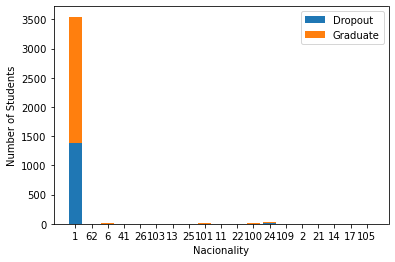

Target,Dropout,Graduate,pct graduate,pct dropout
Nacionality,,,,
1,1389,2155,0.608070,0.391930
2,0,2,1.000000,0.000000
6,4,4,0.500000,0.500000
11,0,3,1.000000,0.000000
13,0,1,1.000000,0.000000
14,0,1,1.000000,0.000000
17,1,0,0.000000,1.000000
21,1,0,0.000000,1.000000
22,4,8,0.666667,0.333333


In [300]:
plot_temp, df_temp = provide_stacked_bar_individual("Nacionality", df_initial)
df_temp["pct graduate"] = df_temp["Graduate"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp["pct dropout"] = df_temp["Dropout"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp

On Special Needs

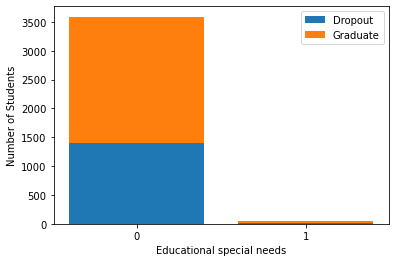

Target,Dropout,Graduate,pct graduate,pct dropout
Educational special needs,,,,
0,1404,2186,0.608914,0.391086
1,17,23,0.575000,0.425000


In [301]:
plot_temp, df_temp = provide_stacked_bar_individual("Educational special needs", df_initial)
df_temp["pct graduate"] = df_temp["Graduate"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp["pct dropout"] = df_temp["Dropout"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp

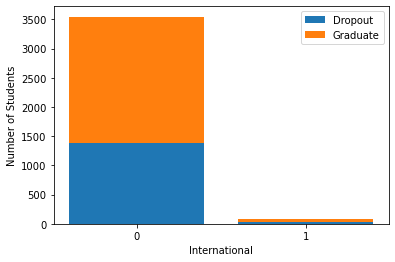

Target,Dropout,Graduate,pct graduate,pct dropout
International,,,,
0,1389,2155,0.608070,0.391930
1,32,54,0.627907,0.372093


In [302]:
plot_temp, df_temp = provide_stacked_bar_individual("International", df_initial)
df_temp["pct graduate"] = df_temp["Graduate"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp["pct dropout"] = df_temp["Dropout"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp

At this point, I would consider dropping unemployment rate, inflation rate, and GDP as it looks like these don't have a relationship through its ordinality

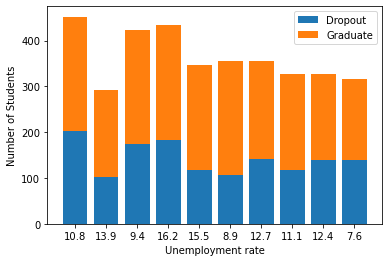

Target,Dropout,Graduate,pct graduate,pct dropout
Unemployment rate,,,,
7.6,202,250,0.553097,0.446903
8.9,102,189,0.649485,0.350515
9.4,174,250,0.589623,0.410377
10.8,182,253,0.581609,0.418391
11.1,117,230,0.662824,0.337176
12.4,107,248,0.698592,0.301408
12.7,141,215,0.603933,0.396067
13.9,118,208,0.638037,0.361963
15.5,139,189,0.576220,0.423780


In [303]:
plot_temp, df_temp = provide_stacked_bar_individual("Unemployment rate", df_initial)
df_temp["pct graduate"] = df_temp["Graduate"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp["pct dropout"] = df_temp["Dropout"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp

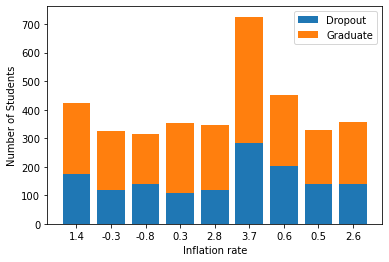

Target,Dropout,Graduate,pct graduate,pct dropout
Inflation rate,,,,
-0.8,174,250,0.589623,0.410377
-0.3,118,208,0.638037,0.361963
0.3,139,177,0.560127,0.439873
0.5,107,248,0.698592,0.301408
0.6,117,230,0.662824,0.337176
1.4,284,442,0.608815,0.391185
2.6,202,250,0.553097,0.446903
2.8,139,189,0.576220,0.423780
3.7,141,215,0.603933,0.396067


In [304]:
plot_temp, df_temp = provide_stacked_bar_individual("Inflation rate", df_initial)
df_temp["pct graduate"] = df_temp["Graduate"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp["pct dropout"] = df_temp["Dropout"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp

The "sweet" range with Inflation Rate is 2% or below (https://www.federalreserve.gov/faqs/5D58E72F066A4DBDA80BBA659C55F774.htm#:~:text=The%20Federal%20Reserve%20has%20not,percent%20or%20a%20bit%20below.), so let's categorize that

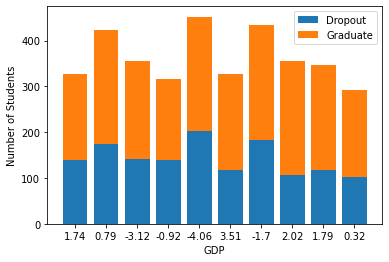

Target,Dropout,Graduate,pct graduate,pct dropout
GDP,,,,
-4.06,139,189,0.576220,0.423780
-3.12,174,250,0.589623,0.410377
-1.70,141,215,0.603933,0.396067
-0.92,139,177,0.560127,0.439873
0.32,202,250,0.553097,0.446903
0.79,118,208,0.638037,0.361963
1.74,182,253,0.581609,0.418391
1.79,107,248,0.698592,0.301408
2.02,117,230,0.662824,0.337176


In [305]:
plot_temp, df_temp = provide_stacked_bar_individual("GDP", df_initial)
df_temp["pct graduate"] = df_temp["Graduate"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp["pct dropout"] = df_temp["Dropout"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp

Thus, it should be sufficient for us to drop these variables as there may not be sufficient evidence to direct the model to an accurate prediction. In this case, we can run a k-fold cross validation

In [306]:
for_drop_df = df_initial.loc[:]
for_drop_df["Inflation Good Range"] = for_drop_df["Inflation rate"].apply(lambda x: 1 if (x > 0.3 and x < 2) else 0)

to_drop = ["Nacionality", "Educational special needs", "International", "GDP", "Inflation rate", "Unemployment rate"]
df_dropped = for_drop_df.drop(to_drop, axis=1)
df_dropped

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Mother's qualification,Father's qualification,Mother's occupation,...,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Target,for_counting,Inflation Good Range
0,1,17,5,171,1,1,122.0,19,12,5,...,20,0,0,0,0,0.000000,0,Dropout,1,1
1,1,15,1,9254,1,1,160.0,1,3,3,...,19,0,6,6,6,14.000000,0,Graduate,1,0
2,1,1,5,9070,1,1,122.0,37,37,9,...,19,0,6,0,0,0.000000,0,Dropout,1,1
3,1,17,2,9773,1,1,122.0,38,37,5,...,20,0,6,8,6,13.428571,0,Graduate,1,0
4,2,39,1,8014,0,1,100.0,37,38,9,...,45,0,6,9,5,12.333333,0,Graduate,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,5,...,19,0,6,7,5,13.600000,0,Graduate,1,0
4420,1,1,2,9773,1,1,120.0,1,1,9,...,18,0,6,6,6,12.000000,0,Dropout,1,1
4421,1,1,1,9500,1,1,154.0,37,37,9,...,30,0,7,8,7,14.912500,0,Dropout,1,0
4422,1,1,1,9147,1,1,180.0,37,37,7,...,20,0,5,5,5,13.800000,0,Graduate,1,0


In [308]:
marital_encod = pd.get_dummies(df_dropped["Marital status"], prefix="marital_status")
app_mode_encod = pd.get_dummies(df_dropped["Application mode"], prefix="app_mode")
course_encod = pd.get_dummies(df_dropped["Course"], prefix="course")
prev_qual_encod = pd.get_dummies(df_dropped["Previous qualification"], prefix="previous_qualifcation")
mothers_qual_encod = pd.get_dummies(df_dropped["Mother's qualification"], prefix="mothers_qual")
fathers_qual_encod = pd.get_dummies(df_dropped["Father's qualification"], prefix="fathers_qual")
mothers_occu_encod = pd.get_dummies(df_dropped["Mother's occupation"], prefix="mothers_occu")
fathers_occu_encod = pd.get_dummies(df_dropped["Father's occupation"], prefix="fathers_occu")
#nacion_encod = pd.get_dummies(df_dropped["Nacionality"], prefix="nacionality")

temp_to_model = pd.concat([df_dropped, marital_encod, app_mode_encod, course_encod, prev_qual_encod, mothers_qual_encod, fathers_qual_encod, mothers_occu_encod, fathers_occu_encod], axis=1) 
temp_to_model = temp_to_model.drop(["Marital status", "Application mode", "Course", "Previous qualification", "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", "for_counting"], axis=1)

temp_to_model['Target'] = temp_to_model['Target'].map({"Graduate": 1, "Dropout": 0})
provide_strat_kfold(temp_to_model)  # previous Naive Bayes was 0.7898071625344352

NAIVE BAYES
ACCURACY LIST:  [0.7823691460055097, 0.7865013774104683, 0.8016528925619835, 0.778236914600551, 0.8071625344352618]
AVERAGE ACCURACY SCORE: 0.7911845730027549
F1 LIST: [0.822072072072072, 0.8275862068965517, 0.8344827586206898, 0.8251900108577633, 0.8426966292134832]
AVERAGE F1 SCORE: 0.830405535532112
----------------------------------
DECISION TREE
ACCURACY LIST: [0.7988980716253443, 0.8140495867768595, 0.8305785123966942, 0.8278236914600551, 0.8278236914600551]
AVERAGE ACCURACY SCORE: 0.8198347107438015
F1 LIST: [0.8344671201814059, 0.8439306358381502, 0.8597491448118586, 0.8597081930415265, 0.856815578465063]
AVERAGE F1 SCORE: 0.8509341344676008
DEPTHS LIST: [30, 33, 28, 29, 24]
AVERAGE DEPTH: 28.8
----------------------------------
RANDOM FOREST
ACCURACY LIST:  [0.8898071625344353, 0.8774104683195593, 0.8994490358126722, 0.8801652892561983, 0.8856749311294766]
AVERAGE ACCURACY SCORE: 0.8865013774104684
F1 LIST: [0.9126637554585153, 0.9023051591657519, 0.920738327904451

### Data Analysis - Variables to regroup

First is Application mode, this is how we organize them:

```
Ordinance
26 - Ordinance No. 533-A/99, item b2) (Different Plan) 
27 - Ordinance No. 533-A/99, item b3 (Other Institution) 
2 - Ordinance No. 612/93 
10 - Ordinance No. 854-B/99 15 - International student (bachelor) 

General Contingent
1 - 1st phase - general contingent
17 - 2nd phase - general contingent 
18 - 3rd phase - general contingent

Special Contingent
5 - 1st phase - special contingent (Azores Island) 
16 - 1st phase - special contingent (Madeira Island)


Diploma Holders
53 - Short cycle diploma holders 
44 - Technological specialization diploma holders 

Transfer / Change
57 - Change of institution/course (International)	
51 - Change of institution/course
43 - Change of course 
42 - Transfer 

Mature Students: 
7 - Holders of other higher courses 
39 - Over 23 years old 

In [309]:
# Stealing Jen's Method :)
# Define a function to map the values of application mode
def categorize_app_mode(app_mode_num):
    ordinance = {26, 27, 2, 10}
    g_cont = {1, 17, 18}
    special_cont = {5, 16}
    diploma = {53, 44}
    transfer_change = {57, 51, 43, 52}
    
    if app_mode_num in ordinance:
        return "Ordinance"
    elif app_mode_num in g_cont:
        return "General Contigent"
    elif app_mode_num in special_cont:
        return "Special Contingent"
    elif app_mode_num in diploma:
        return "Diploma Holders"
    else:
        return "Mature Students"  # Returning 0 for "Other" category

df_dropped['Application mode Recategorized'] = df_dropped['Application mode'].apply(categorize_app_mode)
df_dropped

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Target,for_counting,Inflation Good Range,Application mode Recategorized
0,1,17,5,171,1,1,122.0,19,12,5,...,0,0,0,0,0.000000,0,Dropout,1,1,General Contigent
1,1,15,1,9254,1,1,160.0,1,3,3,...,0,6,6,6,14.000000,0,Graduate,1,0,Mature Students
2,1,1,5,9070,1,1,122.0,37,37,9,...,0,6,0,0,0.000000,0,Dropout,1,1,General Contigent
3,1,17,2,9773,1,1,122.0,38,37,5,...,0,6,8,6,13.428571,0,Graduate,1,0,General Contigent
4,2,39,1,8014,0,1,100.0,37,38,9,...,0,6,9,5,12.333333,0,Graduate,1,0,Mature Students
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,5,...,0,6,7,5,13.600000,0,Graduate,1,0,General Contigent
4420,1,1,2,9773,1,1,120.0,1,1,9,...,0,6,6,6,12.000000,0,Dropout,1,1,General Contigent
4421,1,1,1,9500,1,1,154.0,37,37,9,...,0,7,8,7,14.912500,0,Dropout,1,0,General Contigent
4422,1,1,1,9147,1,1,180.0,37,37,7,...,0,5,5,5,13.800000,0,Graduate,1,0,General Contigent


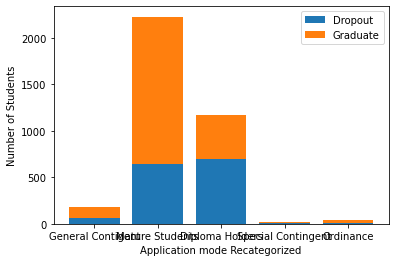

Target,Dropout,Graduate,pct graduate,pct dropout
Application mode Recategorized,,,,
Diploma Holders,67,115,0.631868,0.368132
General Contigent,646,1583,0.710184,0.289816
Mature Students,694,472,0.404803,0.595197
Ordinance,7,8,0.533333,0.466667
Special Contingent,7,31,0.815789,0.184211


In [310]:
plot_temp, df_temp = provide_stacked_bar_individual("Application mode Recategorized", df_dropped)
df_temp["pct graduate"] = df_temp["Graduate"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp["pct dropout"] = df_temp["Dropout"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp

We do see a lot of variance between the percentages, so I would say that this is a keep (iffy-ist one is Ordinance)

In [311]:
marital_encod = pd.get_dummies(df_dropped["Marital status"], prefix="marital_status")
app_mode_encod = pd.get_dummies(df_dropped["Application mode Recategorized"], prefix="app_mode")
course_encod = pd.get_dummies(df_dropped["Course"], prefix="course")
prev_qual_encod = pd.get_dummies(df_dropped["Previous qualification"], prefix="previous_qualifcation")
mothers_qual_encod = pd.get_dummies(df_dropped["Mother's qualification"], prefix="mothers_qual")
fathers_qual_encod = pd.get_dummies(df_dropped["Father's qualification"], prefix="fathers_qual")
mothers_occu_encod = pd.get_dummies(df_dropped["Mother's occupation"], prefix="mothers_occu")
fathers_occu_encod = pd.get_dummies(df_dropped["Father's occupation"], prefix="fathers_occu")


temp_to_model = pd.concat([df_dropped, marital_encod, app_mode_encod, course_encod, prev_qual_encod, mothers_qual_encod, fathers_qual_encod, mothers_occu_encod, fathers_occu_encod], axis=1) # nacion_encod
temp_to_model = temp_to_model.drop(["Application mode", "Application mode Recategorized",
                                    "Course", "Previous qualification", "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", "for_counting"], axis=1)
temp_to_model['Target'] = temp_to_model['Target'].map({"Graduate": 1, "Dropout": 0})
provide_strat_kfold(temp_to_model)  # previous Naive Bayes was 0.7911

NAIVE BAYES
ACCURACY LIST:  [0.778236914600551, 0.7865013774104683, 0.7975206611570248, 0.7727272727272727, 0.7988980716253443]
AVERAGE ACCURACY SCORE: 0.7867768595041322
F1 LIST: [0.8176670441676104, 0.8256467941507312, 0.830057803468208, 0.819672131147541, 0.8355855855855855]
AVERAGE F1 SCORE: 0.8257258717039353
----------------------------------
DECISION TREE
ACCURACY LIST: [0.8112947658402204, 0.8181818181818182, 0.8429752066115702, 0.8292011019283747, 0.8360881542699724]
AVERAGE ACCURACY SCORE: 0.8275482093663911
F1 LIST: [0.8476084538375973, 0.8475750577367206, 0.8707482993197279, 0.8616071428571428, 0.8624277456647398]
AVERAGE F1 SCORE: 0.8579933398831857
DEPTHS LIST: [31, 28, 27, 27, 25]
AVERAGE DEPTH: 27.6
----------------------------------
RANDOM FOREST
ACCURACY LIST:  [0.8829201101928374, 0.8801652892561983, 0.9049586776859504, 0.8842975206611571, 0.8801652892561983]
AVERAGE ACCURACY SCORE: 0.8865013774104684
F1 LIST: [0.9077090119435396, 0.9049180327868853, 0.92459016393442

Surprisingly, re-categorizing it would decrease accuracy, thus we'll remove re-categorization

In [313]:
if "Application mode Recategorized" in df_dropped.columns:
    df_dropped = df_dropped.drop(["Application mode Recategorized"], axis=1)
df_dropped.columns

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance\t', 'Previous qualification',
       'Previous qualification (grade)', 'Mother's qualification',
       'Father's qualification', 'Mother's occupation', 'Father's occupation',
       'Admission grade', 'Displaced', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)', 'Target',
       'for_counting', 'Inflation Good Range'],
      dtype='object')

Next is students' qualification the way we organize this is:

```
Secondary Education:
1 - Secondary education 

Higher education:
2 - Higher education - bachelor's degree 
3 - Higher education - degree
4 - Higher education - master's 
5 - Higher education - doctorate 
6 - Frequency of higher education 
40 - Higher education - degree (1st cycle)
43 - Higher education - master (2nd cycle)

Basic Education:
9 - 12th year of schooling - not completed 
10 - 11th year of schooling - not completed 
12 - Other - 11th year of schooling 
14 - 10th year of schooling 
15 - 10th year of schooling - not completed 
19 - Basic education 3rd cycle (9th/10th/11th year) or equiv. 
38 - Basic education 2nd cycle (6th/7th/8th year) or equiv. 

Vocational
39 - Technological specialization course 
42 - Professional higher technical course 


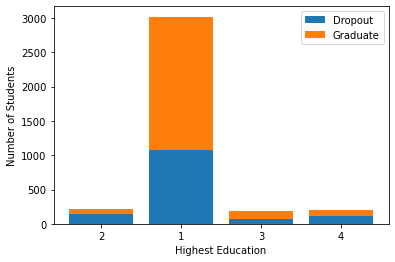

Target,Dropout,Graduate,pct graduate,pct dropout
Highest Education,,,,
1,149,63,0.297170,0.702830
2,1078,1941,0.642928,0.357072
3,75,117,0.609375,0.390625
4,119,88,0.425121,0.574879


In [314]:
# Define a function to map the values of "Previous quialification" to broader categories
def categorize_education(previous_qualification):
    secondary_edu = {1}
    higher_edu = {2, 3, 4, 5, 6, 40, 43}
    basic_edu = {9, 10, 12, 14, 15, 19, 38}
    vocational = {39, 42}

    # we're providing numbers as this can be ranked
    if previous_qualification in secondary_edu:
        return 2
    elif previous_qualification in higher_edu:
        return 4
    elif previous_qualification in basic_edu:
        return 1
    elif previous_qualification in vocational:
        return 3
    else:
        return 0  # Returning 0 for "Other" category

df_dropped['Highest Education'] = df_dropped['Previous qualification'].apply(categorize_education)
plot_temp, df_temp = provide_stacked_bar_individual("Highest Education", df_dropped)
df_temp["pct graduate"] = df_temp["Graduate"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp["pct dropout"] = df_temp["Dropout"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp

Testing Education:

In [316]:
marital_encod = pd.get_dummies(df_dropped["Marital status"], prefix="marital_status")
app_mode_encod = pd.get_dummies(df_dropped["Application mode"], prefix="app_mode")
course_encod = pd.get_dummies(df_dropped["Course"], prefix="course")
prev_qual_encod = pd.get_dummies(df_dropped["Previous qualification"], prefix="previous_qualifcation")
mothers_qual_encod = pd.get_dummies(df_dropped["Mother's qualification"], prefix="mothers_qual")
fathers_qual_encod = pd.get_dummies(df_dropped["Father's qualification"], prefix="fathers_qual")
mothers_occu_encod = pd.get_dummies(df_dropped["Mother's occupation"], prefix="mothers_occu")
fathers_occu_encod = pd.get_dummies(df_dropped["Father's occupation"], prefix="fathers_occu")
highest_edu_encod = pd.get_dummies(df_dropped["Highest Education"], prefix="highest_edu")

temp_to_model = pd.concat([df_dropped, app_mode_encod, marital_encod, course_encod, mothers_qual_encod, fathers_qual_encod, mothers_occu_encod, fathers_occu_encod, highest_edu_encod], axis=1) # nacion_encod prev_qual_encod
temp_to_model = temp_to_model.drop(["Highest Education", "Previous qualification", "Marital status", "Application mode", "Course", "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", "for_counting"], axis=1)

temp_to_model['Target'] = temp_to_model['Target'].map({"Graduate": 1, "Dropout": 0})
provide_strat_kfold(temp_to_model)  # previous Naive Bayes was 0.7911845730027549

NAIVE BAYES
ACCURACY LIST:  [0.7851239669421488, 0.7878787878787878, 0.7988980716253443, 0.7768595041322314, 0.8099173553719008]
AVERAGE ACCURACY SCORE: 0.7917355371900826
F1 LIST: [0.8243243243243245, 0.8285077951002227, 0.8317972350230416, 0.8239130434782608, 0.8449438202247191]
AVERAGE F1 SCORE: 0.8306972436301138
----------------------------------
DECISION TREE
ACCURACY LIST: [0.8085399449035813, 0.8209366391184573, 0.8429752066115702, 0.8360881542699724, 0.8347107438016529]
AVERAGE ACCURACY SCORE: 0.8286501377410469
F1 LIST: [0.8436445444319459, 0.8498845265588916, 0.8710407239819005, 0.8655367231638418, 0.863013698630137]
AVERAGE F1 SCORE: 0.8586240433533433
DEPTHS LIST: [30, 32, 31, 29, 24]
AVERAGE DEPTH: 29.2
----------------------------------
RANDOM FOREST
ACCURACY LIST:  [0.8829201101928374, 0.8746556473829201, 0.9035812672176309, 0.8746556473829201, 0.8801652892561983]
AVERAGE ACCURACY SCORE: 0.8831955922865014
F1 LIST: [0.9079089924160346, 0.9003285870755751, 0.924078091106

Categorizing education increases accuracy, thus we keep - Pretty good variance across the board

In [318]:
if "Previous qualification" in df_dropped.columns:
    df_dropped = df_dropped.drop(["Previous qualification"], axis=1)
print(df_dropped.columns)

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance\t', 'Previous qualification (grade)',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Debtor', 'Tuition fees up to date', 'Gender',
       'Scholarship holder', 'Age at enrollment',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)', 'Target',
       'for_counting', 'Inflation Good Range', 'Highest Education',
       'Mother's qualification - grouped', 'Father's qualification - grouped'],
      dtype='object')


Next is going to be father's and mother's qualification. For mother's and father's qualification, we'll try one-hot encoding at the end. The way we group qualification is the following:

```
GROUPED (POST-SECONDARY) :
5 - Higher Education - Doctorate 
44 - Higher Education - Doctorate (3rd cycle)
4 - Higher Education - Master's 
43 - Higher Education - Master (2nd cycle) 
2 - Higher Education - Bachelor's Degree 
3 - Higher Education - Degree 
40 - Higher education - degree (1st cycle)


GROUPED (VOCATIONAL):
22 - Technical-professional course 
18 - General commerce course
39 - Technological specialization course 
41 - Specialized higher studies course 
42 - Professional higher technical course
31 - General Course of Administration and Commerce
33 - Supplementary Accounting and Administration

GROUPED - BASIC EDUCATION:
1 - Secondary Education - 12th Year of Schooling or Eq. 
9 - 12th Year of Schooling - Not Completed 
12 - Other - 11th Year of Schooling 
10 - 11th Year of Schooling - Not Completed
14 - 10th Year of Schooling 
19 - Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.
13 - 2nd year complementary high school course
20 - Complementary High School Course
25 - Complementary High School Course 

GROUPED - BASIC EDUCATION:
26 - 7th year of schooling 
11 - 7th Year (Old) 
27 - 2nd cycle of the general high school course 
29 - 9th Year of Schooling - Not Completed 
30 - 8th year of schooling 
38 - Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv. 
37 - Basic education 1st cycle (4th/5th year) or equiv. 

GROUPED - NO EDUCATION, BUT WITH LITERACY SKILLS:
36 - Can read without having a 4th year of schooling 

GROUPED - NO EDUCATION:
35 - Can't read or write 

UNKNOWN:
6 - Frequency of Higher Education 
34 - Unknown

In [319]:
# Define a function to map the values for parent's qualification to broader categories
def categorize_parent_qualification(previous_qualification):
    post_second = {5, 44, 4, 43, 2, 3, 40}
    vocational = {22, 18, 39, 41, 42, 31, 33}
    secondary = {1, 9, 12, 10, 14, 19, 13, 20, 25}
    basic = {26, 11, 27, 29, 30, 38, 37}
    no_ed_lit = {36}
    no_ed = {35}


    # we're providing numbers as this can be ranked
    if previous_qualification in no_ed:
        return 0
    elif previous_qualification in no_ed_lit:
        return 1
    elif previous_qualification in basic:
        return 2
    elif previous_qualification in secondary:
        return 3
    elif previous_qualification in vocational:
        return 4
    elif previous_qualification in post_second:
        return 5
    else:
        return None  # Returning None for unknowns

df_dropped["Mother's qualification - grouped"] = df_dropped["Mother's qualification"].apply(categorize_parent_qualification)
df_dropped["Father's qualification - grouped"] = df_dropped["Father's qualification"].apply(categorize_parent_qualification)
df_dropped = df_dropped.dropna()
df_dropped.astype({"Father's qualification - grouped": "int", "Mother's qualification - grouped": "int"})

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification (grade),Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,...,Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Target,for_counting,Inflation Good Range,Highest Education,Mother's qualification - grouped,Father's qualification - grouped
0,1,17,5,171,1,122.0,19,12,5,9,...,0,0,0.000000,0,Dropout,1,1,2,3,3
1,1,15,1,9254,1,160.0,1,3,3,3,...,6,6,14.000000,0,Graduate,1,0,2,3,5
2,1,1,5,9070,1,122.0,37,37,9,9,...,0,0,0.000000,0,Dropout,1,1,2,2,2
3,1,17,2,9773,1,122.0,38,37,5,3,...,8,6,13.428571,0,Graduate,1,0,2,2,2
4,2,39,1,8014,0,100.0,37,38,9,9,...,9,5,12.333333,0,Graduate,1,0,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,125.0,1,1,5,4,...,7,5,13.600000,0,Graduate,1,0,2,3,3
4420,1,1,2,9773,1,120.0,1,1,9,9,...,6,6,12.000000,0,Dropout,1,1,2,3,3
4421,1,1,1,9500,1,154.0,37,37,9,9,...,8,7,14.912500,0,Dropout,1,0,2,2,2
4422,1,1,1,9147,1,180.0,37,37,7,4,...,5,5,13.800000,0,Graduate,1,0,2,2,2


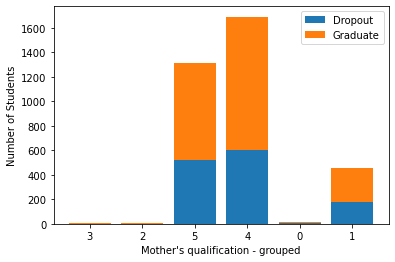

Target,Dropout,Graduate,pct graduate,pct dropout
Mother's qualification - grouped,,,,
0,2,1,0.333333,0.666667
1,2,1,0.333333,0.666667
2,522,790,0.602134,0.397866
3,600,1092,0.645390,0.354610
4,9,9,0.500000,0.500000
5,179,279,0.609170,0.390830


In [320]:
plot_temp, df_temp = provide_stacked_bar_individual("Mother's qualification - grouped", df_dropped)
df_temp["pct graduate"] = df_temp["Graduate"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp["pct dropout"] = df_temp["Dropout"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp

Looks like its worth keeping - surprisingly, it peaks when the mother's highest education is secondary

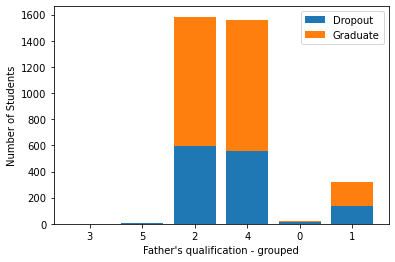

Target,Dropout,Graduate,pct graduate,pct dropout
Father's qualification - grouped,,,,
0,2,0,0.000000,1.000000
1,3,3,0.500000,0.500000
2,597,987,0.623106,0.376894
3,559,998,0.640976,0.359024
4,15,6,0.285714,0.714286
5,138,178,0.563291,0.436709


In [321]:
plot_temp, df_temp = provide_stacked_bar_individual("Father's qualification - grouped", df_dropped)
df_temp["pct graduate"] = df_temp["Graduate"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp["pct dropout"] = df_temp["Dropout"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp

Similar sentiment about Father's. The thing is that, if we feed this into a model, it's hard to see a relationship. So, I would say, let's just change the education levels as categorical values

In [322]:
# Define a function to map the values for parent's qualification to broader categories
def categorize_parent_qualification_again(previous_qualification):
    post_second = {5, 44, 4, 43, 2, 3, 40}
    vocational = {22, 18, 39, 41, 42, 31, 33}
    secondary = {1, 9, 12, 10, 14, 19, 13, 20, 25}
    basic = {26, 11, 27, 29, 30, 38, 37}
    no_ed_lit = {36}
    no_ed = {35}


    # we're providing numbers as this can be ranked
    if previous_qualification in no_ed:
        return "No Education"
    elif previous_qualification in no_ed_lit:
        return "No Education - has literacy skills"
    elif previous_qualification in basic:
        return "Basic Level of Education"
    elif previous_qualification in secondary:
        return "Secondary Level of Education"
    elif previous_qualification in vocational:
        return "Vocational"
    elif previous_qualification in post_second:
        return "Post-Secondary"
    else:
        return None  # Returning None for unknowns

df_dropped["Mother's qualification - grouped"] = df_dropped["Mother's qualification"].apply(categorize_parent_qualification_again)
df_dropped["Father's qualification - grouped"] = df_dropped["Father's qualification"].apply(categorize_parent_qualification_again)
to_drop = ["Father's qualification", "Mother's qualification"]
df_dropped = df_dropped.drop(to_drop, axis=1)
df_dropped

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification (grade),Mother's occupation,Father's occupation,Admission grade,Displaced,...,Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Target,for_counting,Inflation Good Range,Highest Education,Mother's qualification - grouped,Father's qualification - grouped
0,1,17,5,171,1,122.0,5,9,127.3,1,...,0,0,0.000000,0,Dropout,1,1,2,Secondary Level of Education,Secondary Level of Education
1,1,15,1,9254,1,160.0,3,3,142.5,1,...,6,6,14.000000,0,Graduate,1,0,2,Secondary Level of Education,Post-Secondary
2,1,1,5,9070,1,122.0,9,9,124.8,1,...,0,0,0.000000,0,Dropout,1,1,2,Basic Level of Education,Basic Level of Education
3,1,17,2,9773,1,122.0,5,3,119.6,1,...,8,6,13.428571,0,Graduate,1,0,2,Basic Level of Education,Basic Level of Education
4,2,39,1,8014,0,100.0,9,9,141.5,0,...,9,5,12.333333,0,Graduate,1,0,2,Basic Level of Education,Basic Level of Education
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,125.0,5,4,122.2,0,...,7,5,13.600000,0,Graduate,1,0,2,Secondary Level of Education,Secondary Level of Education
4420,1,1,2,9773,1,120.0,9,9,119.0,1,...,6,6,12.000000,0,Dropout,1,1,2,Secondary Level of Education,Secondary Level of Education
4421,1,1,1,9500,1,154.0,9,9,149.5,1,...,8,7,14.912500,0,Dropout,1,0,2,Basic Level of Education,Basic Level of Education
4422,1,1,1,9147,1,180.0,7,4,153.8,1,...,5,5,13.800000,0,Graduate,1,0,2,Basic Level of Education,Basic Level of Education


In [324]:
marital_encod = pd.get_dummies(df_dropped["Marital status"], prefix="marital_status")
app_mode_encod = pd.get_dummies(df_dropped["Application mode"], prefix="app_mode")
course_encod = pd.get_dummies(df_dropped["Course"], prefix="course")
mothers_qual_encod = pd.get_dummies(df_dropped["Mother's qualification - grouped"], prefix="mothers_qual")
fathers_qual_encod = pd.get_dummies(df_dropped["Father's qualification - grouped"], prefix="fathers_qual")
mothers_occu_encod = pd.get_dummies(df_dropped["Mother's occupation"], prefix="mothers_occu")
fathers_occu_encod = pd.get_dummies(df_dropped["Father's occupation"], prefix="fathers_occu")
highest_edu_encod = pd.get_dummies(df_dropped["Highest Education"], prefix="highest_edu")

temp_to_model = pd.concat([df_dropped, app_mode_encod, marital_encod, course_encod, mothers_qual_encod, fathers_qual_encod, mothers_occu_encod, fathers_occu_encod, highest_edu_encod], axis=1) # nacion_encod prev_qual_encod
temp_to_model = temp_to_model.drop(["Highest Education", "Father's qualification - grouped", "Mother's qualification - grouped", "Marital status", "Application mode", "Course", "Mother's occupation", "Father's occupation", "for_counting"], axis=1)

temp_to_model['Target'] = temp_to_model['Target'].map({"Graduate": 1, "Dropout": 0})
provide_strat_kfold(temp_to_model)  # previous Naive Bayes was 0.7917355371900826

NAIVE BAYES
ACCURACY LIST:  [0.8108882521489972, 0.793400286944046, 0.7905308464849354, 0.7847919655667145, 0.7977044476327116]
AVERAGE ACCURACY SCORE: 0.7954631597554809
F1 LIST: [0.8489702517162471, 0.8329466357308585, 0.8325688073394495, 0.8325892857142858, 0.8413948256467941]
AVERAGE F1 SCORE: 0.8376939612295269
----------------------------------
DECISION TREE
ACCURACY LIST: [0.836676217765043, 0.8206599713055954, 0.8249641319942611, 0.8077474892395983, 0.830703012912482]
AVERAGE ACCURACY SCORE: 0.824150164643396
F1 LIST: [0.8695652173913043, 0.8520710059171598, 0.8584686774941994, 0.8430913348946135, 0.8659090909090909]
AVERAGE F1 SCORE: 0.8578210653212736
DEPTHS LIST: [26, 27, 26, 28, 26]
AVERAGE DEPTH: 26.6
----------------------------------
RANDOM FOREST
ACCURACY LIST:  [0.8911174785100286, 0.8923959827833573, 0.8737446197991392, 0.8694404591104734, 0.8766140602582496]
AVERAGE ACCURACY SCORE: 0.8806625200922497
F1 LIST: [0.9159292035398231, 0.9165739710789768, 0.902439024390243

So, it's worthwhile categorizing!

Next is marital status; I remember in the data there is Facto Union where parents have a legally recognized marriage. As for Legally separated, we can group this as divorced. Looking at the distributions:

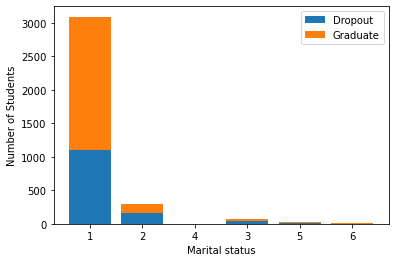

Target,Dropout,Graduate,pct graduate,pct dropout
Marital status,,,,
1,1104,1987,0.642834,0.357166
2,156,140,0.472973,0.527027
3,1,1,0.500000,0.500000
4,38,32,0.457143,0.542857
5,11,11,0.500000,0.500000
6,4,1,0.200000,0.800000


In [325]:
plot_temp, df_temp = provide_stacked_bar_individual("Marital status", df_dropped)
df_temp["pct graduate"] = df_temp["Graduate"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp["pct dropout"] = df_temp["Dropout"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp

In [331]:
def categorize_marital_status(marital_status):
    single = {1}
    together = {2, 5}
    widowed = {3}
    separated = {4, 6}


    if marital_status in single:
        return "Single"
    elif marital_status in together:
        return "Together"
    elif marital_status in widowed:
        return "Widowed"
    elif marital_status in separated:
        return "Separated"

df_dropped["Marital status - regrouped"] = df_dropped["Marital status"].apply(categorize_marital_status)
df_dropped

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification (grade),Mother's occupation,Father's occupation,Admission grade,Displaced,...,Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Target,for_counting,Inflation Good Range,Highest Education,Mother's qualification - grouped,Father's qualification - grouped,Marital status - regrouped
0,1,17,5,171,1,122.0,5,9,127.3,1,...,0,0.000000,0,Dropout,1,1,2,Secondary Level of Education,Secondary Level of Education,Single
1,1,15,1,9254,1,160.0,3,3,142.5,1,...,6,14.000000,0,Graduate,1,0,2,Secondary Level of Education,Post-Secondary,Single
2,1,1,5,9070,1,122.0,9,9,124.8,1,...,0,0.000000,0,Dropout,1,1,2,Basic Level of Education,Basic Level of Education,Single
3,1,17,2,9773,1,122.0,5,3,119.6,1,...,6,13.428571,0,Graduate,1,0,2,Basic Level of Education,Basic Level of Education,Single
4,2,39,1,8014,0,100.0,9,9,141.5,0,...,5,12.333333,0,Graduate,1,0,2,Basic Level of Education,Basic Level of Education,Together
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,125.0,5,4,122.2,0,...,5,13.600000,0,Graduate,1,0,2,Secondary Level of Education,Secondary Level of Education,Single
4420,1,1,2,9773,1,120.0,9,9,119.0,1,...,6,12.000000,0,Dropout,1,1,2,Secondary Level of Education,Secondary Level of Education,Single
4421,1,1,1,9500,1,154.0,9,9,149.5,1,...,7,14.912500,0,Dropout,1,0,2,Basic Level of Education,Basic Level of Education,Single
4422,1,1,1,9147,1,180.0,7,4,153.8,1,...,5,13.800000,0,Graduate,1,0,2,Basic Level of Education,Basic Level of Education,Single


In [333]:
marital_encod = pd.get_dummies(df_dropped["Marital status - regrouped"], prefix="marital_status")
app_mode_encod = pd.get_dummies(df_dropped["Application mode"], prefix="app_mode")
course_encod = pd.get_dummies(df_dropped["Course"], prefix="course")
mothers_qual_encod = pd.get_dummies(df_dropped["Mother's qualification - grouped"], prefix="mothers_qual")
fathers_qual_encod = pd.get_dummies(df_dropped["Father's qualification - grouped"], prefix="fathers_qual")
mothers_occu_encod = pd.get_dummies(df_dropped["Mother's occupation"], prefix="mothers_occu")
fathers_occu_encod = pd.get_dummies(df_dropped["Father's occupation"], prefix="fathers_occu")
highest_edu_encod = pd.get_dummies(df_dropped["Highest Education"], prefix="highest_edu")

temp_to_model = pd.concat([df_dropped, app_mode_encod, marital_encod, course_encod, mothers_qual_encod, fathers_qual_encod, mothers_occu_encod, fathers_occu_encod, highest_edu_encod], axis=1) # nacion_encod prev_qual_encod
temp_to_model = temp_to_model.drop(["Highest Education", "Father's qualification - grouped", "Mother's qualification - grouped", "Marital status - regrouped", "Marital status", "Application mode", "Course", "Mother's occupation", "Father's occupation", "for_counting"], axis=1)

temp_to_model['Target'] = temp_to_model['Target'].map({"Graduate": 1, "Dropout": 0})
provide_strat_kfold(temp_to_model)  # previous Naive Bayes was 0.79517

NAIVE BAYES
ACCURACY LIST:  [0.8108882521489972, 0.793400286944046, 0.7905308464849354, 0.7847919655667145, 0.7977044476327116]
AVERAGE ACCURACY SCORE: 0.7954631597554809
F1 LIST: [0.8489702517162471, 0.8329466357308585, 0.8325688073394495, 0.8325892857142858, 0.8413948256467941]
AVERAGE F1 SCORE: 0.8376939612295269
----------------------------------
DECISION TREE
ACCURACY LIST: [0.830945558739255, 0.8378766140602583, 0.8220946915351507, 0.8235294117647058, 0.8292682926829268]
AVERAGE ACCURACY SCORE: 0.8287429137564594
F1 LIST: [0.8640552995391704, 0.8696655132641291, 0.8564814814814814, 0.8571428571428571, 0.8633754305396096]
AVERAGE F1 SCORE: 0.8621441163934496
DEPTHS LIST: [27, 27, 26, 28, 26]
AVERAGE DEPTH: 26.8
----------------------------------
RANDOM FOREST
ACCURACY LIST:  [0.8911174785100286, 0.8981348637015782, 0.8823529411764706, 0.8622668579626973, 0.8737446197991392]
AVERAGE ACCURACY SCORE: 0.8815233522299828
F1 LIST: [0.9155555555555556, 0.9210233592880979, 0.9090909090909

Thus, marital status should be grouped

In [334]:
if "Marital status" in df_dropped.columns:
    df_dropped = df_dropped.drop(["Marital status"], axis=1)
df_dropped.columns

Index(['Application mode', 'Application order', 'Course',
       'Daytime/evening attendance\t', 'Previous qualification (grade)',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Debtor', 'Tuition fees up to date', 'Gender',
       'Scholarship holder', 'Age at enrollment',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)', 'Target',
       'for_counting', 'Inflation Good Range', 'Highest Education',
       'Mother's qualification - grouped', 'Father's qualification - grouped',
       'Marital status - regrouped'],
      dtype='object')

From here, Age at enrolment can be considered as well

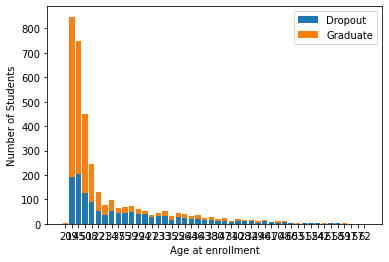

Target,Dropout,Graduate,pct graduate,pct dropout
Age at enrollment,,,,
17,0,3,1.000000,0.000000
18,191,657,0.774764,0.225236
19,204,545,0.727637,0.272363
20,125,323,0.720982,0.279018
21,88,157,0.640816,0.359184
22,54,78,0.590909,0.409091
23,38,41,0.518987,0.481013
24,52,44,0.458333,0.541667
25,43,22,0.338462,0.661538


In [335]:
plot_temp, df_temp = provide_stacked_bar_individual("Age at enrollment", df_dropped)
df_temp["pct graduate"] = df_temp["Graduate"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp["pct dropout"] = df_temp["Dropout"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp

Disregard the image - Students that have an age less than or equal to 20 have a good likelihood, students that have an age, 21-22 have a mediocre likelihood, 23-24 have a 50-50% likelihood, and 25 and older have low likelihoods. Let's categorize that, but in an ordinal way

In [336]:
def categorize_age_at_enrolment(age):
    if age <= 20:
        return 4
    elif age in {21, 22}:
        return 3
    elif age in {23, 24}:
        return 2
    elif age >= 25:
        return 1

df_dropped["Age at enrollment - grouped"] = df_dropped["Age at enrollment"].apply(categorize_age_at_enrolment)
df_dropped

,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification (grade),Mother's occupation,Father's occupation,Admission grade,Displaced,Debtor,...,Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Target,for_counting,Inflation Good Range,Highest Education,Mother's qualification - grouped,Father's qualification - grouped,Marital status - regrouped,Age at enrollment - grouped
0,17,5,171,1,122.0,5,9,127.3,1,0,...,0.000000,0,Dropout,1,1,2,Secondary Level of Education,Secondary Level of Education,Single,4
1,15,1,9254,1,160.0,3,3,142.5,1,0,...,14.000000,0,Graduate,1,0,2,Secondary Level of Education,Post-Secondary,Single,4
2,1,5,9070,1,122.0,9,9,124.8,1,0,...,0.000000,0,Dropout,1,1,2,Basic Level of Education,Basic Level of Education,Single,4
3,17,2,9773,1,122.0,5,3,119.6,1,0,...,13.428571,0,Graduate,1,0,2,Basic Level of Education,Basic Level of Education,Single,4
4,39,1,8014,0,100.0,9,9,141.5,0,0,...,12.333333,0,Graduate,1,0,2,Basic Level of Education,Basic Level of Education,Together,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,6,9773,1,125.0,5,4,122.2,0,0,...,13.600000,0,Graduate,1,0,2,Secondary Level of Education,Secondary Level of Education,Single,4
4420,1,2,9773,1,120.0,9,9,119.0,1,1,...,12.000000,0,Dropout,1,1,2,Secondary Level of Education,Secondary Level of Education,Single,4
4421,1,1,9500,1,154.0,9,9,149.5,1,0,...,14.912500,0,Dropout,1,0,2,Basic Level of Education,Basic Level of Education,Single,1
4422,1,1,9147,1,180.0,7,4,153.8,1,0,...,13.800000,0,Graduate,1,0,2,Basic Level of Education,Basic Level of Education,Single,4


In [ ]:
plot_temp, df_temp = provide_stacked_bar_individual("Age at enrollment - grouped", df_dropped)
df_temp["pct graduate"] = df_temp["Graduate"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp["pct dropout"] = df_temp["Dropout"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp

In [342]:
marital_encod = pd.get_dummies(df_dropped["Marital status - regrouped"], prefix="marital_status")
app_mode_encod = pd.get_dummies(df_dropped["Application mode"], prefix="app_mode")
course_encod = pd.get_dummies(df_dropped["Course"], prefix="course")
# prev_qual_encod = pd.get_dummies(df_dropped["Previous qualification"], prefix="previous_qualifcation")
mothers_qual_encod = pd.get_dummies(df_dropped["Mother's qualification - grouped"], prefix="mothers_qual")
fathers_qual_encod = pd.get_dummies(df_dropped["Father's qualification - grouped"], prefix="fathers_qual")
mothers_occu_encod = pd.get_dummies(df_dropped["Mother's occupation"], prefix="mothers_occu")
fathers_occu_encod = pd.get_dummies(df_dropped["Father's occupation"], prefix="fathers_occu")
highest_edu_encod = pd.get_dummies(df_dropped["Highest Education"], prefix="highest_edu")
age_encod = pd.get_dummies(df_dropped["Age at enrollment - grouped"], prefix="age_enc")

temp_to_model = pd.concat([df_dropped, app_mode_encod, marital_encod, course_encod, mothers_qual_encod, fathers_qual_encod, mothers_occu_encod, fathers_occu_encod, highest_edu_encod, age_encod], axis=1) # nacion_encod prev_qual_encod
temp_to_model = temp_to_model.drop(["Highest Education", "Father's qualification - grouped", "Mother's qualification - grouped", "Marital status - regrouped", "Age at enrollment", "Application mode", "Course", "Mother's occupation", "Father's occupation", "for_counting"], axis=1)


temp_to_model['Target'] = temp_to_model['Target'].map({"Graduate": 1, "Dropout": 0})
provide_strat_kfold(temp_to_model)  # previous Naive Bayes was 0.79517

NAIVE BAYES
ACCURACY LIST:  [0.7865329512893983, 0.7890961262553802, 0.7747489239598279, 0.7532281205164992, 0.7919655667144907]
AVERAGE ACCURACY SCORE: 0.7791143377471192
F1 LIST: [0.8261376896149357, 0.8280701754385965, 0.8172293364377183, 0.8036529680365296, 0.8327566320645905]
AVERAGE F1 SCORE: 0.8215693603184742
----------------------------------
DECISION TREE
ACCURACY LIST: [0.8452722063037249, 0.8278335724533716, 0.8278335724533716, 0.812051649928264, 0.8249641319942611]
AVERAGE ACCURACY SCORE: 0.8275910266265987
F1 LIST: [0.8755760368663595, 0.861111111111111, 0.8614318706697459, 0.8478513356562137, 0.8610478359908884]
AVERAGE F1 SCORE: 0.8614036380588639
DEPTHS LIST: [27, 27, 25, 23, 26]
AVERAGE DEPTH: 25.6
----------------------------------
RANDOM FOREST
ACCURACY LIST:  [0.8982808022922636, 0.9024390243902439, 0.8852223816355811, 0.8651362984218077, 0.8694404591104734]
AVERAGE ACCURACY SCORE: 0.8841037931700739
F1 LIST: [0.9211986681465039, 0.9242761692650334, 0.9109131403118

Accuracy decreases, so let's not use it

In [343]:
if "Age at enrollment - grouped" in df_dropped.columns:
    df_dropped = df_dropped.drop(["Age at enrollment - grouped"], axis=1)
df_dropped.columns

Index(['Application mode', 'Application order', 'Course',
       'Daytime/evening attendance\t', 'Previous qualification (grade)',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Debtor', 'Tuition fees up to date', 'Gender',
       'Scholarship holder', 'Age at enrollment',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)', 'Target',
       'for_counting', 'Inflation Good Range', 'Highest Education',
       'Mother's qualification - grouped', 'Father's qualification - grouped',
       'Marital status - regrouped'],
      dtype='object')

To suggest early interventions, we'll only consider first sem. One of the items to investigate is the number of credits enrolled in the first sem

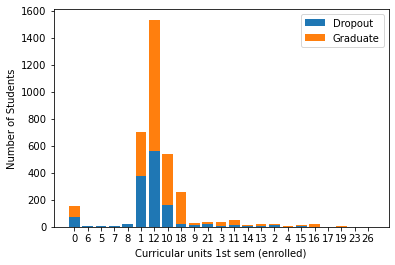

Target,Dropout,Graduate,pct graduate,pct dropout
Curricular units 1st sem (enrolled),,,,
0,76,75,0.496689,0.503311
1,5,0,0.000000,1.000000
2,5,2,0.285714,0.714286
3,7,0,0.000000,1.000000
4,19,0,0.000000,1.000000
5,377,325,0.462963,0.537037
6,562,970,0.633159,0.366841
7,159,382,0.706100,0.293900
8,24,237,0.908046,0.091954


In [345]:
plot_temp, df_temp = provide_stacked_bar_individual('Curricular units 1st sem (enrolled)', df_dropped)
df_temp["pct graduate"] = df_temp["Graduate"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp["pct dropout"] = df_temp["Dropout"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp

So this is representing a fairly normal distribution - what's surprising is that at, 0 enrolled units, students have a 50% graduation rate - which can indicate that this is not an admission problem. In addition, this may not be a great metric to use as the number of units doesn't have any trends with graduation. Let's look into grades

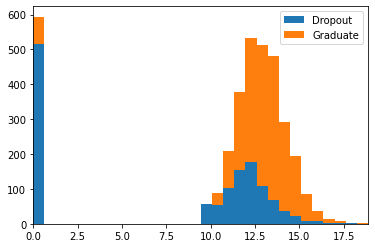

,Curricular units 1st sem (grade),Dropout,Graduate,pct graduate,pct dropout
"[0.0, 0.629)",0.000000,517,77,0.129630,0.870370
"[0.629, 1.258)",0.629167,0,0,0.000000,0.000000
"[1.258, 1.888)",1.258333,0,0,0.000000,0.000000
"[1.888, 2.517)",1.887500,0,0,0.000000,0.000000
"[2.517, 3.146)",2.516667,0,0,0.000000,0.000000
"[3.146, 3.775)",3.145833,0,0,0.000000,0.000000
"[3.775, 4.404)",3.775000,0,0,0.000000,0.000000
"[4.404, 5.033)",4.404167,0,0,0.000000,0.000000
"[5.033, 5.662)",5.033333,0,0,0.000000,0.000000
"[5.662, 6.292)",5.662500,0,0,0.000000,0.000000


In [346]:
plot_temp, df_temp = provide_histogram_individual('Curricular units 1st sem (grade)', df_dropped, 30)
df_temp["pct graduate"] = df_temp["Graduate"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp["pct dropout"] = df_temp["Dropout"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp.fillna(0)

I played around with the bins - we see a nice normal distribution on the right, but we also see two noticeable bins where students tend to drop out - more specifically, after 12.583. Uncertainty ranges around [10.067, 12.583), and the remainder, we find that more students are dropping out

In [347]:
def categorize_grade_fs(grade):
    if grade >= 12.583:
        return 3
    elif grade >= 10.067:
        return 2
    else:
        return 1

df_dropped["First Sem Grade Indicator"] = df_dropped["Curricular units 1st sem (grade)"].apply(categorize_grade_fs)
df_dropped

,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification (grade),Mother's occupation,Father's occupation,Admission grade,Displaced,Debtor,...,Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Target,for_counting,Inflation Good Range,Highest Education,Mother's qualification - grouped,Father's qualification - grouped,Marital status - regrouped,First Sem Grade Indicator
0,17,5,171,1,122.0,5,9,127.3,1,0,...,0.000000,0,Dropout,1,1,2,Secondary Level of Education,Secondary Level of Education,Single,1
1,15,1,9254,1,160.0,3,3,142.5,1,0,...,14.000000,0,Graduate,1,0,2,Secondary Level of Education,Post-Secondary,Single,3
2,1,5,9070,1,122.0,9,9,124.8,1,0,...,0.000000,0,Dropout,1,1,2,Basic Level of Education,Basic Level of Education,Single,1
3,17,2,9773,1,122.0,5,3,119.6,1,0,...,13.428571,0,Graduate,1,0,2,Basic Level of Education,Basic Level of Education,Single,3
4,39,1,8014,0,100.0,9,9,141.5,0,0,...,12.333333,0,Graduate,1,0,2,Basic Level of Education,Basic Level of Education,Together,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,6,9773,1,125.0,5,4,122.2,0,0,...,13.600000,0,Graduate,1,0,2,Secondary Level of Education,Secondary Level of Education,Single,3
4420,1,2,9773,1,120.0,9,9,119.0,1,1,...,12.000000,0,Dropout,1,1,2,Secondary Level of Education,Secondary Level of Education,Single,2
4421,1,1,9500,1,154.0,9,9,149.5,1,0,...,14.912500,0,Dropout,1,0,2,Basic Level of Education,Basic Level of Education,Single,3
4422,1,1,9147,1,180.0,7,4,153.8,1,0,...,13.800000,0,Graduate,1,0,2,Basic Level of Education,Basic Level of Education,Single,3


In [349]:
marital_encod = pd.get_dummies(df_dropped["Marital status - regrouped"], prefix="marital_status")
app_mode_encod = pd.get_dummies(df_dropped["Application mode"], prefix="app_mode")
course_encod = pd.get_dummies(df_dropped["Course"], prefix="course")
mothers_qual_encod = pd.get_dummies(df_dropped["Mother's qualification - grouped"], prefix="mothers_qual")
fathers_qual_encod = pd.get_dummies(df_dropped["Father's qualification - grouped"], prefix="fathers_qual")
mothers_occu_encod = pd.get_dummies(df_dropped["Mother's occupation"], prefix="mothers_occu")
fathers_occu_encod = pd.get_dummies(df_dropped["Father's occupation"], prefix="fathers_occu")
highest_edu_encod = pd.get_dummies(df_dropped["Highest Education"], prefix="highest_edu")
first_sem_grad_encode = pd.get_dummies(df_dropped["First Sem Grade Indicator"], prefix="first_sem_grade")

temp_to_model = pd.concat([df_dropped, app_mode_encod, marital_encod, course_encod, mothers_qual_encod, fathers_qual_encod, mothers_occu_encod, fathers_occu_encod, highest_edu_encod, first_sem_grad_encode], axis=1) # nacion_encod prev_qual_encod
temp_to_model = temp_to_model.drop(["Highest Education", "Father's qualification - grouped", "Mother's qualification - grouped", "Marital status - regrouped", "Age at enrollment", "Curricular units 1st sem (grade)", "First Sem Grade Indicator", 
"Application mode", "Course", "Mother's occupation", "Father's occupation", "for_counting"], axis=1)


temp_to_model['Target'] = temp_to_model['Target'].map({"Graduate": 1, "Dropout": 0})
provide_strat_kfold(temp_to_model)  # previous Naive Bayes was 0.79517; weirdly, accuracy doesnt change that much if I don't one-hot it

NAIVE BAYES
ACCURACY LIST:  [0.836676217765043, 0.8249641319942611, 0.806312769010043, 0.7733142037302726, 0.8177905308464849]
AVERAGE ACCURACY SCORE: 0.8118115706692208
F1 LIST: [0.8695652173913043, 0.859122401847575, 0.8457142857142856, 0.8232662192393736, 0.8558456299659478]
AVERAGE F1 SCORE: 0.8507027508316973
----------------------------------
DECISION TREE
ACCURACY LIST: [0.828080229226361, 0.8263988522238164, 0.8278335724533716, 0.8020086083213773, 0.8192252510760402]
AVERAGE ACCURACY SCORE: 0.8207093026601934
F1 LIST: [0.8581560283687943, 0.8574793875147232, 0.8623853211009175, 0.8380281690140845, 0.8538283062645011]
AVERAGE F1 SCORE: 0.8539754424526041
DEPTHS LIST: [28, 28, 26, 23, 27]
AVERAGE DEPTH: 26.4
----------------------------------
RANDOM FOREST
ACCURACY LIST:  [0.8939828080229226, 0.9010043041606887, 0.8780487804878049, 0.8694404591104734, 0.8694404591104734]
AVERAGE ACCURACY SCORE: 0.8823833621784726
F1 LIST: [0.9175946547884186, 0.9232480533926586, 0.906077348066298

Accuracy increased, thus we keep

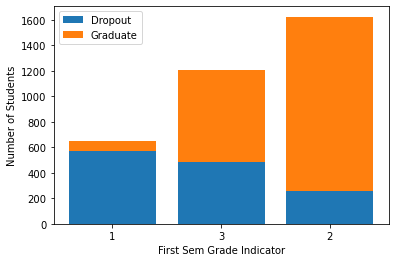

Target,Dropout,Graduate,pct graduate,pct dropout
First Sem Grade Indicator,,,,
1,574,78,0.119632,0.880368
2,486,722,0.597682,0.402318
3,254,1372,0.843788,0.156212


In [351]:
plot_temp, df_temp = provide_stacked_bar_individual("First Sem Grade Indicator", df_dropped)
df_temp["pct graduate"] = df_temp["Graduate"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp["pct dropout"] = df_temp["Dropout"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp

I am interested to see average grades per credit, before we commit. Let's look into the distributions

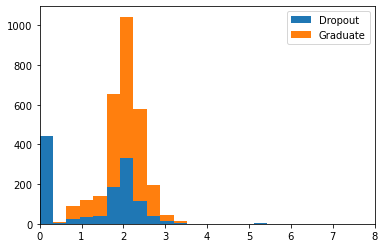

,Average Grade per Credit,Dropout,Graduate,pct graduate,pct dropout
"[0.0, 0.32)",0.00,441,2,0.004515,0.995485
"[0.32, 0.64)",0.32,2,9,0.818182,0.181818
"[0.64, 0.96)",0.64,26,62,0.704545,0.295455
"[0.96, 1.28)",0.96,36,83,0.697479,0.302521
"[1.28, 1.6)",1.28,40,101,0.716312,0.283688
"[1.6, 1.92)",1.60,184,470,0.718654,0.281346
"[1.92, 2.24)",1.92,330,713,0.683605,0.316395
"[2.24, 2.56)",2.24,114,463,0.802426,0.197574
"[2.56, 2.88)",2.56,41,154,0.789744,0.210256
"[2.88, 3.2)",2.88,14,29,0.674419,0.325581


In [352]:
df_dropped["Average Grade per Credit"] = df_dropped["Curricular units 1st sem (grade)"] / df_dropped["Curricular units 1st sem (enrolled)"]
# df_dropped = df_dropped.fillna(9)  # unobtainable grade, using 9 to differentiate divide by 0 errors since I do want to still visualize it
plot_temp, df_temp = provide_histogram_individual('Average Grade per Credit', df_dropped, 25)
df_temp["pct graduate"] = df_temp["Graduate"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp["pct dropout"] = df_temp["Dropout"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp.fillna(0)

In [353]:
df_dropped.loc[df_dropped["Average Grade per Credit"].isnull() ].value_counts("Target", normalize=True)

Target
Dropout     0.503311
Graduate    0.496689
dtype: float64

Overall, we do see a pretty normal distribution, and the majority of students who have an average credit less than 0.36 drop out - seems like a good metric to use. Other than that, I can't seem to find a relationship.

In [354]:
df_dropped["Average Grade Indicator"] = df_dropped["Average Grade per Credit"].apply(lambda x: 1 if x > 0.36 else 0)
df_dropped

,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification (grade),Mother's occupation,Father's occupation,Admission grade,Displaced,Debtor,...,Target,for_counting,Inflation Good Range,Highest Education,Mother's qualification - grouped,Father's qualification - grouped,Marital status - regrouped,First Sem Grade Indicator,Average Grade per Credit,Average Grade Indicator
0,17,5,171,1,122.0,5,9,127.3,1,0,...,Dropout,1,1,2,Secondary Level of Education,Secondary Level of Education,Single,1,NaN,0
1,15,1,9254,1,160.0,3,3,142.5,1,0,...,Graduate,1,0,2,Secondary Level of Education,Post-Secondary,Single,3,2.333333,1
2,1,5,9070,1,122.0,9,9,124.8,1,0,...,Dropout,1,1,2,Basic Level of Education,Basic Level of Education,Single,1,0.000000,0
3,17,2,9773,1,122.0,5,3,119.6,1,0,...,Graduate,1,0,2,Basic Level of Education,Basic Level of Education,Single,3,2.238095,1
4,39,1,8014,0,100.0,9,9,141.5,0,0,...,Graduate,1,0,2,Basic Level of Education,Basic Level of Education,Together,2,2.055556,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,6,9773,1,125.0,5,4,122.2,0,0,...,Graduate,1,0,2,Secondary Level of Education,Secondary Level of Education,Single,3,2.266667,1
4420,1,2,9773,1,120.0,9,9,119.0,1,1,...,Dropout,1,1,2,Secondary Level of Education,Secondary Level of Education,Single,2,2.000000,1
4421,1,1,9500,1,154.0,9,9,149.5,1,0,...,Dropout,1,0,2,Basic Level of Education,Basic Level of Education,Single,3,2.130357,1
4422,1,1,9147,1,180.0,7,4,153.8,1,0,...,Graduate,1,0,2,Basic Level of Education,Basic Level of Education,Single,3,2.760000,1


In [355]:
marital_encod = pd.get_dummies(df_dropped["Marital status - regrouped"], prefix="marital_status")
app_mode_encod = pd.get_dummies(df_dropped["Application mode"], prefix="app_mode")
course_encod = pd.get_dummies(df_dropped["Course"], prefix="course")
mothers_qual_encod = pd.get_dummies(df_dropped["Mother's qualification - grouped"], prefix="mothers_qual")
fathers_qual_encod = pd.get_dummies(df_dropped["Father's qualification - grouped"], prefix="fathers_qual")
mothers_occu_encod = pd.get_dummies(df_dropped["Mother's occupation"], prefix="mothers_occu")
fathers_occu_encod = pd.get_dummies(df_dropped["Father's occupation"], prefix="fathers_occu")
highest_edu_encod = pd.get_dummies(df_dropped["Highest Education"], prefix="highest_edu")
first_sem_grad_encode = pd.get_dummies(df_dropped["First Sem Grade Indicator"], prefix="first_sem_grade")

temp_to_model = pd.concat([df_dropped, app_mode_encod, marital_encod, course_encod, mothers_qual_encod, fathers_qual_encod, mothers_occu_encod, fathers_occu_encod, highest_edu_encod, first_sem_grad_encode], axis=1) # nacion_encod prev_qual_encod
temp_to_model = temp_to_model.drop(["Highest Education", "Father's qualification - grouped", "Mother's qualification - grouped", "Marital status - regrouped", "Age at enrollment", "Curricular units 1st sem (grade)", "First Sem Grade Indicator", 
"Average Grade per Credit", "Application mode", "Course", "Mother's occupation", "Father's occupation", "for_counting"], axis=1)


temp_to_model['Target'] = temp_to_model['Target'].map({"Graduate": 1, "Dropout": 0})
provide_strat_kfold(temp_to_model)  # previous Naive Bayes was 0.8118

NAIVE BAYES
ACCURACY LIST:  [0.83810888252149, 0.8278335724533716, 0.8020086083213773, 0.787661406025825, 0.8177905308464849]
AVERAGE ACCURACY SCORE: 0.8146806000337097
F1 LIST: [0.8731762065095399, 0.8636363636363636, 0.8452914798206278, 0.8373626373626374, 0.8590455049944506]
AVERAGE F1 SCORE: 0.8557024384647238
----------------------------------
DECISION TREE
ACCURACY LIST: [0.833810888252149, 0.8278335724533716, 0.8292682926829268, 0.8149210903873745, 0.8278335724533716]
AVERAGE ACCURACY SCORE: 0.8267334832458386
F1 LIST: [0.8648018648018648, 0.861111111111111, 0.862108922363847, 0.8505214368482039, 0.8601398601398601]
AVERAGE F1 SCORE: 0.8597366390529775
DEPTHS LIST: [28, 28, 25, 23, 27]
AVERAGE DEPTH: 26.2
----------------------------------
RANDOM FOREST
ACCURACY LIST:  [0.9011461318051576, 0.8895265423242468, 0.8780487804878049, 0.8737446197991392, 0.8751793400286944]
AVERAGE ACCURACY SCORE: 0.8835290828890086
F1 LIST: [0.9232480533926585, 0.9145394006659266, 0.9058693244739756,

Pretty good increase

Checking Previous Qualification Grade

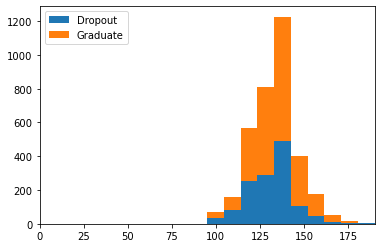

,Previous qualification (grade),Dropout,Graduate,pct graduate,pct dropout
"[95.0, 104.5)",95.0,32,39,0.549296,0.450704
"[104.5, 114.0)",104.5,79,79,0.500000,0.500000
"[114.0, 123.5)",114.0,254,312,0.551237,0.448763
"[123.5, 133.0)",123.5,289,523,0.644089,0.355911
"[133.0, 142.5)",133.0,488,738,0.601958,0.398042
"[142.5, 152.0)",142.5,104,298,0.741294,0.258706
"[152.0, 161.5)",152.0,46,129,0.737143,0.262857
"[161.5, 171.0)",161.5,13,40,0.754717,0.245283
"[171.0, 180.5)",171.0,7,12,0.631579,0.368421
"[180.5, 190.0)",180.5,1,2,0.666667,0.333333


In [356]:
plot_temp, df_temp = provide_histogram_individual("Previous qualification (grade)", df_dropped, 10)
df_temp["pct graduate"] = df_temp["Graduate"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp["pct dropout"] = df_temp["Dropout"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp

For previous qualification, anything above 142.5 seems like a good jump to distinguish students graduating and uncertainty as we see that relationship

In [357]:
df_dropped["Previous Qualification Grade Indicator"] = df_dropped["Previous qualification (grade)"].apply(lambda x: 1 if x > 142.5 else 0)
df_dropped

,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification (grade),Mother's occupation,Father's occupation,Admission grade,Displaced,Debtor,...,for_counting,Inflation Good Range,Highest Education,Mother's qualification - grouped,Father's qualification - grouped,Marital status - regrouped,First Sem Grade Indicator,Average Grade per Credit,Average Grade Indicator,Previous Qualification Grade Indicator
0,17,5,171,1,122.0,5,9,127.3,1,0,...,1,1,2,Secondary Level of Education,Secondary Level of Education,Single,1,NaN,0,0
1,15,1,9254,1,160.0,3,3,142.5,1,0,...,1,0,2,Secondary Level of Education,Post-Secondary,Single,3,2.333333,1,1
2,1,5,9070,1,122.0,9,9,124.8,1,0,...,1,1,2,Basic Level of Education,Basic Level of Education,Single,1,0.000000,0,0
3,17,2,9773,1,122.0,5,3,119.6,1,0,...,1,0,2,Basic Level of Education,Basic Level of Education,Single,3,2.238095,1,0
4,39,1,8014,0,100.0,9,9,141.5,0,0,...,1,0,2,Basic Level of Education,Basic Level of Education,Together,2,2.055556,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,6,9773,1,125.0,5,4,122.2,0,0,...,1,0,2,Secondary Level of Education,Secondary Level of Education,Single,3,2.266667,1,0
4420,1,2,9773,1,120.0,9,9,119.0,1,1,...,1,1,2,Secondary Level of Education,Secondary Level of Education,Single,2,2.000000,1,0
4421,1,1,9500,1,154.0,9,9,149.5,1,0,...,1,0,2,Basic Level of Education,Basic Level of Education,Single,3,2.130357,1,1
4422,1,1,9147,1,180.0,7,4,153.8,1,0,...,1,0,2,Basic Level of Education,Basic Level of Education,Single,3,2.760000,1,1


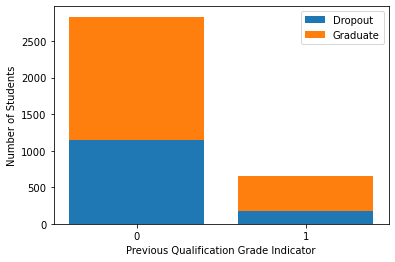

Target,Dropout,Graduate,pct graduate,pct dropout
Previous Qualification Grade Indicator,,,,
0,1142,1691,0.596894,0.403106
1,172,481,0.736600,0.263400


In [358]:
plot_temp, df_temp = provide_stacked_bar_individual("Previous Qualification Grade Indicator", df_dropped)
df_temp["pct graduate"] = df_temp["Graduate"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp["pct dropout"] = df_temp["Dropout"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp

In [359]:
marital_encod = pd.get_dummies(df_dropped["Marital status - regrouped"], prefix="marital_status")
app_mode_encod = pd.get_dummies(df_dropped["Application mode"], prefix="app_mode")
course_encod = pd.get_dummies(df_dropped["Course"], prefix="course")
mothers_qual_encod = pd.get_dummies(df_dropped["Mother's qualification - grouped"], prefix="mothers_qual")
fathers_qual_encod = pd.get_dummies(df_dropped["Father's qualification - grouped"], prefix="fathers_qual")
mothers_occu_encod = pd.get_dummies(df_dropped["Mother's occupation"], prefix="mothers_occu")
fathers_occu_encod = pd.get_dummies(df_dropped["Father's occupation"], prefix="fathers_occu")
highest_edu_encod = pd.get_dummies(df_dropped["Highest Education"], prefix="highest_edu")
first_sem_grad_encode = pd.get_dummies(df_dropped["First Sem Grade Indicator"], prefix="first_sem_grade")

temp_to_model = pd.concat([df_dropped, app_mode_encod, marital_encod, course_encod, mothers_qual_encod, fathers_qual_encod, mothers_occu_encod, fathers_occu_encod, highest_edu_encod, first_sem_grad_encode], axis=1) # nacion_encod prev_qual_encod
temp_to_model = temp_to_model.drop(["Highest Education", "Father's qualification - grouped", "Mother's qualification - grouped", "Marital status - regrouped", "Age at enrollment", "Curricular units 1st sem (grade)", "First Sem Grade Indicator", 
"Average Grade per Credit", "Previous qualification (grade)", "Application mode", "Course", "Mother's occupation", "Father's occupation", "for_counting"], axis=1)


temp_to_model['Target'] = temp_to_model['Target'].map({"Graduate": 1, "Dropout": 0})
provide_strat_kfold(temp_to_model)  # previous Naive Bayes was 0.8146806000337097

NAIVE BAYES
ACCURACY LIST:  [0.83810888252149, 0.8278335724533716, 0.8091822094691535, 0.7890961262553802, 0.8235294117647058]
AVERAGE ACCURACY SCORE: 0.8175500404928202
F1 LIST: [0.8726042841037205, 0.8633257403189066, 0.8503937007874016, 0.8389923329682366, 0.8631813125695217]
AVERAGE F1 SCORE: 0.8576994741495575
----------------------------------
DECISION TREE
ACCURACY LIST: [0.835243553008596, 0.8263988522238164, 0.8249641319942611, 0.8077474892395983, 0.8220946915351507]
AVERAGE ACCURACY SCORE: 0.8232897436002844
F1 LIST: [0.8667439165701043, 0.8578143360752055, 0.859122401847575, 0.8441860465116279, 0.855813953488372]
AVERAGE F1 SCORE: 0.856736130898577
DEPTHS LIST: [28, 26, 26, 23, 27]
AVERAGE DEPTH: 26.0
----------------------------------
RANDOM FOREST
ACCURACY LIST:  [0.8982808022922636, 0.8938307030129125, 0.8809182209469153, 0.866571018651363, 0.8837876614060258]
AVERAGE ACCURACY SCORE: 0.884677681261896
F1 LIST: [0.9211986681465039, 0.9177777777777778, 0.9078801331853497, 0

Keep; lastly in distributions is admission grade

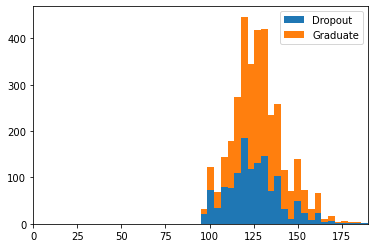

,Admission grade,Dropout,Graduate,pct graduate,pct dropout
"[95.0, 98.8)",95.0,22,10,0.312500,0.687500
"[98.8, 102.6)",98.8,74,48,0.393443,0.606557
"[102.6, 106.4)",102.6,35,33,0.485294,0.514706
"[106.4, 110.2)",106.4,79,65,0.451389,0.548611
"[110.2, 114.0)",110.2,77,101,0.567416,0.432584
"[114.0, 117.8)",114.0,109,165,0.602190,0.397810
"[117.8, 121.6)",117.8,185,262,0.586130,0.413870
"[121.6, 125.4)",121.6,119,225,0.654070,0.345930
"[125.4, 129.2)",125.4,131,287,0.686603,0.313397
"[129.2, 133.0)",129.2,147,274,0.650831,0.349169


In [183]:
plot_temp, df_temp = provide_histogram_individual("Admission grade", df_dropped, 25)
df_temp["pct graduate"] = df_temp["Graduate"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp["pct dropout"] = df_temp["Dropout"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp

It's hard to say that we can find a linear relationship to segment. Thus, it's not considered